# Notebook inspired in the bellow solutions discussed
* [CNN, Independence, Counts Magic [0.92174 private]](https://www.kaggle.com/jganzabal/cnn-independence-counts-magic-0-92174-private)
* [List of Fake Samples and Public/Private LB split](https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split)
* [200 Magical Models - Santander - [0.920]](https://www.kaggle.com/cdeotte/200-magical-models-santander-0-920/comments)

# Download and import packages
Download keras-contrib for CyclicLR and santander_helper for auc metric and custom Datagenerator

In [ ]:
#! pip install git+https://www.github.com/keras-team/keras-contrib.git
! wget https://github.com/jganzabal/santander_kaggle_solutions_tests/raw/master/santander_helper.py

In [1]:
#Import base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from tqdm import tqdm_notebook as tqdm
import random
from scipy import interp
import statsmodels.api as sm
warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('ggplot')
%matplotlib inline
#Import sklearn libraries
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold,cross_val_predict,cross_validate,cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler


In [2]:
#Help functions

def plot_2d_space(X, y, label='Classes'):
    plt.figure(figsize=(8,8))
    markers = ['o', 's']
    for l, m in zip(np.unique(y), markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1]
            , label=l, marker=m
            )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()
#ROC/AUC
def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

#### According with the discussions related with this competition, the creator include syntetic samples accros all the data

> # Divide fake from real:

This is taken from https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

In [3]:
# GET INDICIES OF REAL TEST DATA FOR FE
#######################
# TAKE FROM YAG320'S KERNEL
# https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

test_path = '../input/test.csv'
train_path = '../input/train.csv'

df_test = pd.read_csv(test_path)
df_test.drop(['ID_code'], axis=1, inplace=True)
df_test = df_test.values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in range(df_test.shape[1]):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print('Found',len(real_samples_indexes),'real test')
print('Found',len(synthetic_samples_indexes),'fake test')

###################

d = {}
for i in range(200): d['var_'+str(i)] = 'float32'
d['target'] = 'uint8'
d['ID_code'] = 'object'

train = pd.read_csv('../input/train.csv', dtype=d)
test = pd.read_csv('../input/test.csv', dtype=d)

print('Loaded',len(train),'rows of train')
print('Loaded',len(test),'rows of test')
print('Found',len(real_samples_indexes),'real test')
print('Found',len(synthetic_samples_indexes),'fake test')

###################

d = {}
for i in range(200): d['var_'+str(i)] = 'float32'
d['target'] = 'uint8'
d['ID_code'] = 'object'

train = pd.read_csv(train_path, dtype=d)
test = pd.read_csv(test_path, dtype=d)

print('Loaded',len(train),'rows of train')
print('Loaded',len(test),'rows of test')

Found 100000 real test
Found 100000 fake test
Loaded 200000 rows of train
Loaded 200000 rows of test
Found 100000 real test
Found 100000 fake test
Loaded 200000 rows of train
Loaded 200000 rows of test


# Add counts to each of the 200 vars
This is taken from https://www.kaggle.com/cdeotte/200-magical-models-santander-0-920/comments, a must read kernel from @cdeotte

In [4]:
# FREQUENCY ENCODE
def encode_FE(df,col,test):
    cv = df[col].value_counts()
    nm = col+'_FE'
    df[nm] = df[col].map(cv)
    test[nm] = test[col].map(cv)
    test[nm].fillna(0,inplace=True)
    if cv.max()<=255:
        df[nm] = df[nm].astype('uint8')
        test[nm] = test[nm].astype('uint8')
    else:
        df[nm] = df[nm].astype('uint16')
        test[nm] = test[nm].astype('uint16')        
    return

test['target'] = -1
comb = pd.concat([train,test.loc[real_samples_indexes]],axis=0,sort=True)
for i in range(200): 
    encode_FE(comb,'var_'+str(i),test)
train = comb[:len(train)]; del comb
print('Added 200 new magic features!')

Added 200 new magic features!


In [5]:
del df_test, real_samples_indexes, synthetic_samples_indexes, unique_count, unique_samples, d

# Load and prepare data

In [38]:
#Create DataFrames

# Load data with counts saved in the previous cells
df_train_data = train.drop(columns=['ID_code'])
df_train_X = df_train_data.drop(columns=['target'])

reverse_columns = True
if reverse_columns:
    reverse_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 15, 16, 18, 19, 22, 24, 25, 26,
                    27, 29, 32, 35, 37, 40, 41, 47, 48, 49, 51, 52, 53, 55, 60, 61,
                    62, 65, 66, 67, 69, 70, 71, 74, 78, 79, 82, 84, 89, 90, 91, 94,
                    95, 96, 97, 99, 103, 105, 106, 110, 111, 112, 118, 119, 125, 128,
                    130, 133, 134, 135, 137, 138, 140, 144, 145, 147, 151, 155, 157,
                    159, 161, 162, 163, 164, 167, 168, 170, 171, 173, 175, 176, 179,
                    180, 181, 184, 185, 187, 189, 190, 191, 195, 196, 199,
                    ]

    for j in reverse_list:
        df_train_X[f'var_{j}'] *= -1

In [39]:
#Define X,y
y = df_train_data['target'].values
X = df_train_X.values

print(df_train_X.shape)

(200000, 400)


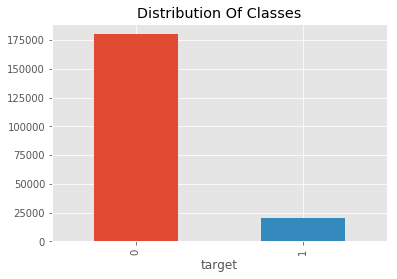

In [40]:
#Check the distribution of target classes
df_train_data.groupby(by="target")["target"].count().plot(kind="bar",title="Distribution Of Classes")

Obs. Test some resample techinique before the next steps

In [41]:
# Normalize data
rs = RobustScaler()
X_scaled_rs = rs.fit_transform(X)

12


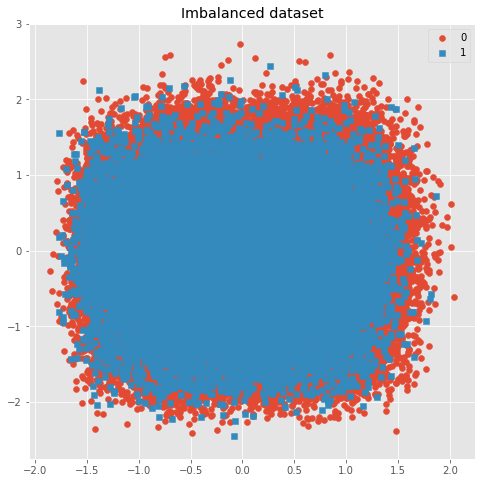

In [42]:
#Let`s plot a 2d scatter plot to see the distribution of 2 random dimensions
n = random.randrange(start=0,stop=198)
print(n)
plot_2d_space(X_scaled_rs[:,n:n+2], y[:], 'Imbalanced dataset')

Maybe we can use the package https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.under_sampling

# Define a Model

In [43]:
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix,roc_curve, auc,roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold,cross_validate,cross_val_predict,cross_val_score,StratifiedKFold
import seaborn as sns

ExtraTreeModel = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                                   max_depth=None, max_features='auto', max_leaf_nodes=None,
                                   min_impurity_decrease=0.0, min_impurity_split=None,
                                   min_samples_leaf=1, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                                   oob_score=False, random_state=None, verbose=0, warm_start=False)

In [ ]:
#Train with cross validation
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for k_train, k_test in tqdm(cv.split(X_scaled_rs, y)):
    probas_ = ExtraTreeModel.fit(X_scaled_rs[k_train], y[k_train]).predict_proba(X_scaled_rs[k_test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[k_test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Create 200 models and ensemble results

In [35]:
#Import NB model
from sklearn.naive_bayes import GaussianNB

def create_NB_Model():
    model = GaussianNB()
    return model

def fit_NB_Model(Model,X,y,cv_splits=5): 
    cv = KFold(n_splits=cv_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train,test in cv.split(X, y):
        probas_ = Model.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    return Model,mean_auc

def get_NB_results(X,y,cv_splits=5):
    model_aucs  = []
    models = {}
    for k in tqdm(range(0,int(X.shape[1]/2))):
        Model = create_NB_Model()
        X_train = X[:,[k,k+200]]#.reshape(-1,1)
        model,auc = fit_NB_Model(Model,X_train,y,cv_splits=cv_splits)
        #Append model
        models["Model_"+str(k)] =model
        model_aucs.append(auc)
        print(str(auc)+str(" AUC Average for Model_")+str(k))
        #Fit each Model
    return models,np.array(model_aucs)

def make_NB_predictions(X_train,y_train,cv,X_test):
    #Create a new array to store results
    train_predictions = np.zeros_like(X_train)
    test_predictions = np.zeros_like(X_test)
    #Fit model
    models,model_aucs = get_NB_results(X_train,y_train,cv_splits=cv)
    #Iterate over the X
    for k in range(0,int(X_train.shape[1]/2)):
        X_train_pred = X_train[:,[k,k+200]]#.reshape(-1,1)
        train_probas_ = models.get("Model_"+str(k)).predict_proba(X_train_pred)[:, 1]
        train_predictions[:, k] = train_probas_
        
    for j in range(0,int(X_test.shape[1]/2)):
        X_test_pred = X_test[:,[j,j+200]]#.reshape(-1,1)
        test_probas_ = models.get("Model_"+str(j)).predict_proba(X_test_pred)[:, 1]
        test_predictions[:, j] = test_probas_
        
    return test_predictions,train_predictions

def save_submit_file(predictions, filename, test_filename=test_path, index_column='ID_code', target_column = 'target'):
    df_test_submit = pd.read_csv(test_filename).set_index(index_column)
    df_test_submit[target_column] = predictions
    df_test_submit[[target_column]].to_csv(filename)
    return 

In [19]:
_,train_predictions = make_NB_predictions(X_train = X_scaled_rs,y_train = y,cv = 5,X_test=X_scaled_rs)

0.5446668633843668 AUC Average for Model_0
0.5443093595766154 AUC Average for Model_1
0.5015586651091261 AUC Average for Model_2
0.5003678144846341 AUC Average for Model_3
0.5088541505424652 AUC Average for Model_4
0.5157237054588303 AUC Average for Model_5
0.4974038639270247 AUC Average for Model_6
0.5261269004178958 AUC Average for Model_7
0.5233458188772102 AUC Average for Model_8
0.5300100374742972 AUC Average for Model_9
0.5371209842786691 AUC Average for Model_10
0.537495436963003 AUC Average for Model_11
0.5425049062872123 AUC Average for Model_12
0.5195409744940269 AUC Average for Model_13
0.5561898933009883 AUC Average for Model_14
0.5226569777617365 AUC Average for Model_15
0.5224919284843325 AUC Average for Model_16
0.5113798387423041 AUC Average for Model_17
0.5232287558802631 AUC Average for Model_18
0.5458011509947147 AUC Average for Model_19
0.5214624316239396 AUC Average for Model_20
0.5050862714773796 AUC Average for Model_21
0.5376210910105645 AUC Average for Model_22

0.5190130075749692 AUC Average for Model_187
0.5334287644466587 AUC Average for Model_188
0.537024758978266 AUC Average for Model_189
0.5268190131338125 AUC Average for Model_190
0.5355400501571236 AUC Average for Model_191
0.5417187943914478 AUC Average for Model_192
0.5302795432364895 AUC Average for Model_193
0.5409761383427186 AUC Average for Model_194
0.530970029514104 AUC Average for Model_195
0.49786970081337906 AUC Average for Model_196
0.5137658340235113 AUC Average for Model_197
0.504654882375274 AUC Average for Model_198
0.5512434060027881 AUC Average for Model_199
0.5219754297336447 AUC Average for Model_200
0.5124342366564217 AUC Average for Model_201
0.5185680644406087 AUC Average for Model_202
0.5040655488793515 AUC Average for Model_203
0.5055820421703603 AUC Average for Model_204
0.5075303658267382 AUC Average for Model_205
0.528178398023989 AUC Average for Model_206
0.4980084818643074 AUC Average for Model_207
0.5012279762094392 AUC Average for Model_208
0.51366351568

0.5122562712632539 AUC Average for Model_370
0.5042702555224969 AUC Average for Model_371
0.5069618874727506 AUC Average for Model_372
0.5073070206840573 AUC Average for Model_373
0.5076431743665698 AUC Average for Model_374
0.5050221726530779 AUC Average for Model_375
0.5024379686105332 AUC Average for Model_376
0.5079061101065253 AUC Average for Model_377
0.5035778663074102 AUC Average for Model_378
0.5223994368403952 AUC Average for Model_379
0.50641985909514 AUC Average for Model_380
0.5078477596861568 AUC Average for Model_381
0.4996469390943903 AUC Average for Model_382
0.49987912945505786 AUC Average for Model_383
0.5042757380966782 AUC Average for Model_384
0.4990167553559946 AUC Average for Model_385
0.4990452095566477 AUC Average for Model_386
0.49752773335072326 AUC Average for Model_387
0.5090603146062121 AUC Average for Model_388
0.5042279241189394 AUC Average for Model_389
0.5114169363914004 AUC Average for Model_390
0.5172479969204828 AUC Average for Model_391
0.50449089

In [20]:
from sklearn.linear_model import LogisticRegression
ensemble_model = LogisticRegression()
ensemble_model.fit(X = train_predictions, y = y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

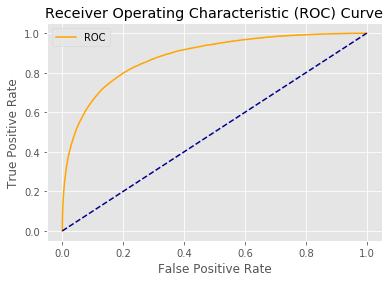

In [21]:
fpr, tpr, thresholds = roc_curve(y, ensemble_model.predict_proba(train_predictions)[:, 1])
plot_roc_curve(fpr, tpr)

# Make predictions

In [36]:
# Normalize test data
df_test = test.drop(columns=['ID_code', 'target'])
X_test = df_test.values
X_test_scaled_rs = rs.fit_transform(X_test)

In [37]:
test_predictions,train_predictions = make_NB_predictions(X_train = X_scaled_rs,y_train = y,cv = 5,X_test=X_test_scaled_rs)

0.5455157908155714 AUC Average for Model_0
0.544785494266752 AUC Average for Model_1
0.518480293106275 AUC Average for Model_2
0.5033673551018779 AUC Average for Model_3
0.5110682535106097 AUC Average for Model_4
0.5181795662649226 AUC Average for Model_5
0.5281009891276601 AUC Average for Model_6
0.5257962994449451 AUC Average for Model_7
0.5232520697622445 AUC Average for Model_8
0.5363148388565077 AUC Average for Model_9
0.5365847742080203 AUC Average for Model_10
0.5376961034278087 AUC Average for Model_11
0.5620249684731844 AUC Average for Model_12
0.523089151474733 AUC Average for Model_13
0.5559366053474707 AUC Average for Model_14
0.5245532560322542 AUC Average for Model_15
0.5228097371195976 AUC Average for Model_16
0.5111195296949709 AUC Average for Model_17
0.5227699321161172 AUC Average for Model_18
0.545426997930339 AUC Average for Model_19
0.520851358693206 AUC Average for Model_20
0.5079900334612039 AUC Average for Model_21
0.5431494734122104 AUC Average for Model_22
0.5

0.5330567886255693 AUC Average for Model_186
0.5185362813383675 AUC Average for Model_187
0.5345480170694402 AUC Average for Model_188
0.5366783798137781 AUC Average for Model_189
0.5283826713084375 AUC Average for Model_190
0.5396314280859966 AUC Average for Model_191
0.5419398025044162 AUC Average for Model_192
0.53142492565912 AUC Average for Model_193
0.5410908768961072 AUC Average for Model_194
0.537826999020606 AUC Average for Model_195
0.5030651934543356 AUC Average for Model_196
0.5202986342340943 AUC Average for Model_197
0.5207918165140674 AUC Average for Model_198
0.551332203158238 AUC Average for Model_199



In [34]:
int(X.shape[1]/2)

200

In [24]:
ensemble_model.fit(X = train_predictions, y = y)
predictions = ensemble_model.predict(test_predictions)


In [25]:
save_submit_file(predictions, "submission_rev4.csv")

In [26]:
from IPython.display import FileLink
FileLink('submission_rev4.csv')

/kaggle/working/submission_rev4.csv